In [6]:
from imutils import paths
!pip install imutils
import imutils
import cv2
import numpy as np

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
# VGG16 used for 16 hidden layer as by name. It is used for feature extraction.
from keras.applications import VGG16
# imagenet_utils do the preprocessing tasks like standarize the RGB value.
from keras.applications import imagenet_utils
# Here is 4 labels 0, 90, 180 and 270. label encoder used to label the images
# into these four labels.
from sklearn.preprocessing import LabelEncoder
# Logistic regression used here for classification the data.
from sklearn.linear_model import LogisticRegression

In [8]:
import pickle

In [9]:
# HDF5 lets us store huge amounts of numerical data, and easily manipulate that data from NumPy.
import h5py

In [10]:
!pip install progressbar

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12074 sha256=a769330c5b1afa8567ba7d1606ebea242426bf589f19d8a7befaf2d99f6220ca
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [11]:
#import other necessary library
import os
import progressbar
import random
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten

In [12]:
#configure setting
# initialize dataset location and after building the dataset store location
dataset_path = r"/kaggle/input/dataset-5/Image 5/Original image"
rotated_path = r"/kaggle/working/dataset-5/Image 5/Rotated image"

# after pre-processing and extract feature store location initialize
hdf5_path = r"..\correcting_rotation234_100dataset.hdf5"
# to serialize the model location initialize
model_path=r"..\Model\orientation_correction_classifier.cpickle"

# initialize vgg16 trained model weights path location
weight_path = r"/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

# initialize batch size and buffer size for predicting in batch and to store the buffer sizes images into file.
batch_size = 32
buffer_size = 1000

In [13]:
# load all the images from dataset path
imagePaths = list(paths.list_images(dataset_path))[:10000]
# randomly shuffle the images for randomness
random.shuffle(imagePaths)

# initialize a dictionary to keep track of the number of each angle and its counter
angles = {}
# initialize the progress bar for customize the progress bar style
widgets = ["Building Dataset: ", progressbar.Percentage(), " ",progressbar.Bar(), " ", progressbar.ETA()]
# we define the maxval in progress bar with the total images from our dataset so that it will end at that iteration.
pbar = progressbar.ProgressBar(maxval=len(imagePaths),widgets=widgets).start()

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    
    # random choose the rotation angle, and load the image
    angle = np.random.choice([0, 90, 180, 270])
    image = cv2.imread(imagePath)

    # if the image is None
    if image is None:
        continue
    
    # rotate the image based on the selected angle, then construct
    # the path to the base output directory
    image = imutils.rotate_bound(image, angle)
    base = os.path.sep.join([rotated_path, str(angle)])

    # if the base path does not exist already, create it
    if not os.path.exists(base):
        os.makedirs(base)

    # extract the image file extension, then construct the full path
    # to the output file
    ext = imagePath[imagePath.rfind("."):]
    outputPath = [base, "image_{}{}".format(str(angles.get(angle, 0)).zfill(5), ext)]
    outputPath = os.path.sep.join(outputPath)

    # save the image
    cv2.imwrite(outputPath, image)
    # update the count for the angle
    c = angles.get(angle, 0)
    angles[angle] = c + 1
    pbar.update(i)


# finish the progress bar
pbar.finish()

# loop over the angles and display counts for each of them
for angle in sorted(angles.keys()):
    print("[INFO] angle={}: {:,}".format(angle, angles[angle]))  
# loop over the angles and display counts for each of them
for angle in sorted(angles.keys()):
    print("[INFO] angle={}: {:,}".format(angle, angles[angle]))  

[INFO] angle=0: 112
[INFO] angle=90: 111
[INFO] angle=180: 113
[INFO] angle=270: 115
[INFO] angle=0: 112
[INFO] angle=90: 111
[INFO] angle=180: 113
[INFO] angle=270: 115


In [14]:
# Before extraction, we need to work with the hdf5 format file. Where the
# extraction file will format
class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images", bufSize=1000):
    # we have given a condtion where the hdf5 files may already exists.
        if os.path.exists(outputPath):
            raise ValueError("The supplied ‘outputPath‘ already "
             "exists and cannot be overwritten. Manually delete "
            "the file before continuing.", outputPath)
        
        # open the HDF5 database for writing and create two datasets:
        # The first database is for to store raw images(extracted features) and
        # another one is for label of the images in integer format.

        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,
        dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0],),
        dtype="int")
        
        # store the buffer size, then initialize the buffer itself
        # along with the index into the datasets
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0
    # In the add method, we are to going to add the rows and labels until the
    # bufSize which we have declared as 1,000 ]
    def add(self, rows, labels):
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)
        # after reached to the buffer
        # size we have flush to reset it.
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()
    # In the flush method, we make sure that the data is not overwriten and
    # tracked the data as it is a very large numpy array
    def flush(self):
        # slicling the data in it before reseting.
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}
    
    def storeClassLabels(self, classLabels):
        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype(vlen=str)
        labelSet = self.db.create_dataset("label_names",(len(classLabels),), dtype=dt)
        labelSet[:] = classLabels

    # no other data left then we just used the close method
    def close(self):
        if len(self.buffer["data"]) > 0:
            self.flush()

        # close the dataset
        self.db.close()

In [15]:
class VGGNet_16:
    
    @staticmethod
    def build(weights_path=None):
        
        model = Sequential() # we define sequential function for building sequential CNN architecture.
        
        model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
        model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        
        model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        
        model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
        
        model.add(Flatten(name='flatten'))

        # Here we used the ImageNet dataset trained VGG-16 model weight for using the transfer learning technique. And
        # we load the trained weights to our model.
        if weights_path:
            model.load_weights(weights_path)

        return model

In [16]:
model=VGGNet_16.build(weight_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [17]:
# initlize the batch size for predicting batch images feature from VGG-16 model at a time.
bs = batch_size

# Here, we load all images path from given rotated_path location.
print("[INFO] loading images...")
imagePaths = list(paths.list_images(rotated_path))
# After loading all images, We shuffling the images for randomness. Because, Our dataset images are sequential category.
random.shuffle(imagePaths)

# For getting the label or class for each class we extract each label from each image path. Because, we have class label folder.
labels = [p.split(os.path.sep)[-2] for p in imagePaths]
# Here, we encode the class level into 0,1,2,3 numeric value.
le = LabelEncoder()
labels = le.fit_transform(labels)

dataset = HDF5DatasetWriter((len(imagePaths), 512 * 7 * 7), hdf5_path, dataKey="features", bufSize=buffer_size)

# here, we store all the class names that we are going to predict. [0,90,180,270]
dataset.storeClassLabels(le.classes_)

# initialize the progress bar for customize the progress bar style
widgets = ["Extracting Features: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
# we define the maxval in progress bar with the total images from our dataset so that it will end at that iteration.
pbar = progressbar.ProgressBar(maxval=len(imagePaths),widgets=widgets).start()

# Here, we are taking the images from imagePaths by batch size. And extract all batch images feature from VGG-16 model
for i in np.arange(0, len(imagePaths), bs):
    
    # we define batchPaths for store all images path from imagePaths by the batch size that we define before.
    batchPaths = imagePaths[i:i + bs]
    # It is same here above line but we actually storing the labels of each batch size images.
    batchLabels = labels[i:i + bs]
    # initilize the batchImages for storing the all batch size images.
    batchImages = []

    # loop over the images and labels in the current batch
    for (j, imagePath) in enumerate(batchPaths):
        
        # we resized all images to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # here, we add extra dimension in the first for each images such as - before image shape (224x224x3) after expand shape
        # (1x224x224x3)
        image = np.expand_dims(image, axis=0)
        
        image = imagenet_utils.preprocess_input(image)
        
        # add the image to the batch
        batchImages.append(image)

    
    # here we convert list to numpy array with verticall stack.
    batchImages = np.vstack(batchImages)
    # Here we are extracting feature from VGG-16 model last layer (flatten layer) by batch.
    features = model.predict(batchImages, batch_size=bs)

    # reshape the features so that each image is represented by
    # a flattened feature vector of the ‘MaxPooling2D‘ outputs
    features = features.reshape((features.shape[0], 512 * 7 * 7))

    # add the features and labels to our HDF5 dataset
    dataset.add(features, batchLabels)
    pbar.update(i)

# close the dataset
dataset.close()
pbar.finish()

[INFO] loading images...


Extracting Features: 100% |#####################################| Time: 0:00:10


In [18]:
# initialize hdf5 dataset path where we store the final images into hdf5 file
db=hdf5_path

# open the HDF5 database for reading
db = h5py.File(db, "r")

# initilize the index of the 75% of the dataset into "i"
i = int(db["labels"].shape[0] * 0.75)

print("[INFO] tuning hyperparameters...")
params = {"C": [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]}

# validation.
model = GridSearchCV(LogisticRegression(max_iter=300), params, cv=3, n_jobs=1)
# here we training the model using 75% of the data among total data
model.fit(db["features"][:i], db["labels"][:i])

# Here we are priting the best parameters values that we got after training the model
print("[INFO] best hyperparameters: {}".format(model.best_params_))

# evaluate the model
print("[INFO] evaluating...")
# here we are predicting the class for getting the test results by test dataset.
preds = model.predict(db["features"][i:])

# here we are priting the classification report after getting the prediction from the model by test data.
print(classification_report(db["labels"][i:], preds,target_names=db["label_names"]))


# serialize the model to disk so that we can use this model next time for prediction
print("[INFO] saving model...")
f = open(model_path, "wb")
f.write(pickle.dumps(model.best_estimator_))
f.close()

# close the database
db.close()

[INFO] tuning hyperparameters...
[INFO] best hyperparameters: {'C': 10000.0}
[INFO] evaluating...
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        27
         180       0.85      0.93      0.89        30
         270       1.00      0.83      0.91        29
          90       0.87      1.00      0.93        27

    accuracy                           0.90       113
   macro avg       0.91      0.90      0.90       113
weighted avg       0.91      0.90      0.90       113

[INFO] saving model...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


[INFO] sampling images...
[INFO] loading network...
[INFO] loading model...


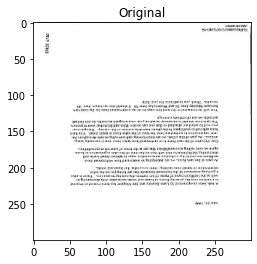

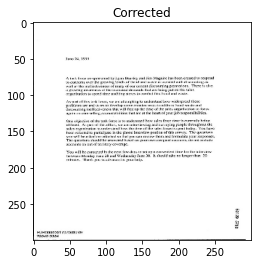

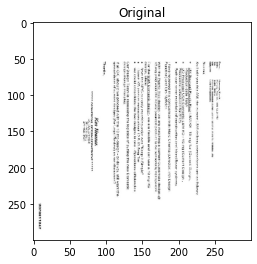

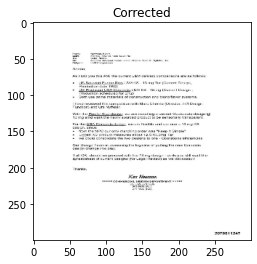

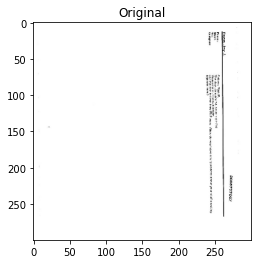

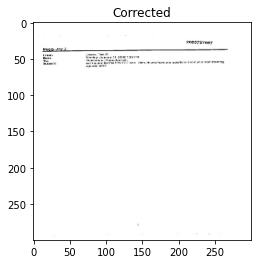

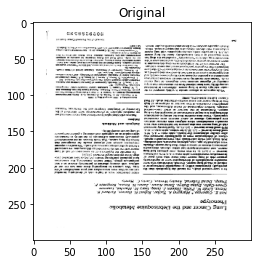

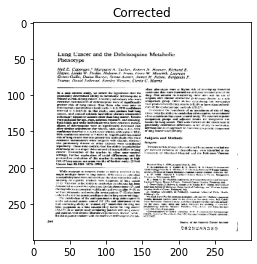

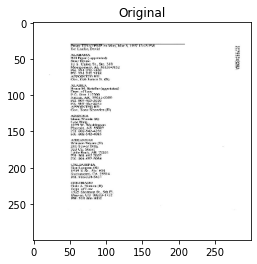

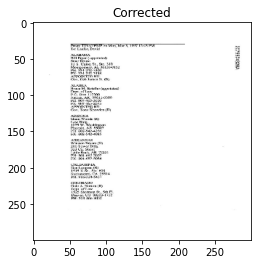

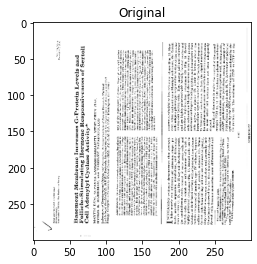

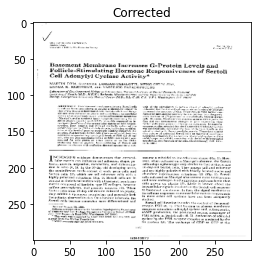

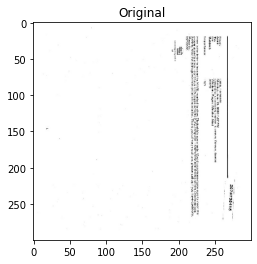

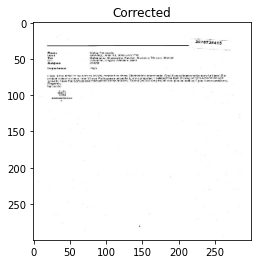

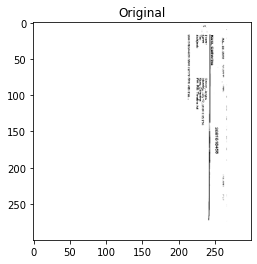

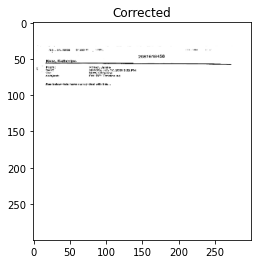

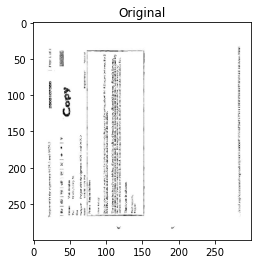

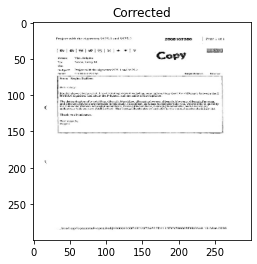

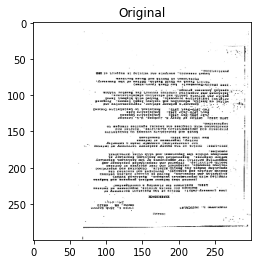

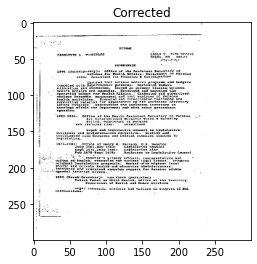

In [20]:
import matplotlib.pyplot as plt
# initialize class label stored path, model location and for testing some random images define the rotation images path
db = hdf5_path
model = model_path
dataset = rotated_path

# load the label names from the HDF5 dataset
db = h5py.File(db)
# converting the labels names into integer
labelNames = [int(angle) for angle in db["label_names"][:]]
# close the database connection
db.close()

# grab the paths to the testing images and randomly sample them
print("[INFO] sampling images...")
# load all the images from rotation path
imagePaths = list(paths.list_images(dataset))
# we choose 10 images randomly for testing without replacement
imagePaths = np.random.choice(imagePaths, size=(10,), replace=False)

# load the VGG16 network for extracting feature for each testing images
print("[INFO] loading network...")
vgg = VGGNet_16.build(weight_path)


# load the orientation model for prediction
print("[INFO] loading model...")
model = pickle.loads(open(model, "rb").read())

# loop over the choosen 10 images for prediction 
for imagePath in imagePaths:
    orig = cv2.imread(imagePath)
    # read the image and resize the into 224x224x3 shape
    image = load_img(imagePath, target_size=(224, 224))
    # convert the image to array
    image = img_to_array(image)
    
    # here, we add extra dimension in the first for each images such as - before image shape (224x224x3) after expand shape
    # (1x224x224x3)
    image = np.expand_dims(image, axis=0)
    
    image = imagenet_utils.preprocess_input(image)

    # pass the image through the VGG-16 network to get the feature vector
    features = vgg.predict(image)
    
    # reshape the feature into 1d array for prediction
    features = features.reshape((features.shape[0], 512 * 7 * 7))
    # now that we have the CNN features, pass these through our
    # classifier to obtain the orientation predictions
    angle = model.predict(features)
    angle = labelNames[angle[0]]
    # now that we have the predicted orientation of the image we can correct it
    rotated = imutils.rotate_bound(orig, 360 - angle)
    orig = cv2.resize(orig, (300,300))
    rotated = cv2.resize(rotated, (300,300))
    # display the original and corrected images
    plt.imshow(orig)
    plt.title("Original")
    plt.show()

    # Display the corrected image 
    plt.imshow(rotated)
    plt.title("Corrected")
    plt.show()
    
